<a href="https://colab.research.google.com/github/singhalvivek/Resnet_on_custom_images/blob/main/Classification_using_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import  imread



from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers.merge import add
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model
from keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os


In [ ]:
n =3
version = 2

In [ ]:
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = "/content/drive/MyDrive/cell_images"

In [ ]:
os.listdir(data_dir)

['train', 'test']

In [ ]:
train_path = data_dir + "/train/"


In [ ]:
test_path = data_dir + "/test/"


In [ ]:
test_path

'/content/drive/MyDrive/cell_images/test/'

In [ ]:
os.listdir(train_path)

['uninfected', 'parasitized']

In [ ]:
os.listdir(train_path+'parasitized')[0]

'C92P53ThinF_IMG_20150821_151224_cell_211.png'

In [ ]:
p_cell = train_path+'parasitized/'+'C92P53ThinF_IMG_20150821_151224_cell_211.png'

In [ ]:
imread(p_cell).shape

(160, 175, 3)

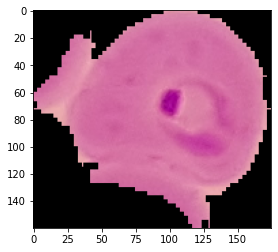

In [ ]:
plt.imshow(imread(p_cell))

In [ ]:
os.listdir(train_path+'uninfected')[0]

'C91P52ThinF_IMG_20150821_124504_cell_76.png'

In [ ]:
u_cell = train_path+'uninfected/'+'C91P52ThinF_IMG_20150821_124504_cell_76.png'

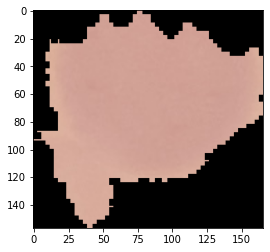

In [ ]:
plt.imshow(imread(u_cell))

In [ ]:
len(os.listdir(train_path+'uninfected'))

12490

In [ ]:
len(os.listdir(train_path+'parasitized'))

12510

In [ ]:
len(os.listdir(test_path+'uninfected'))

1300

In [ ]:
len(os.listdir(test_path+'parasitized'))

1300

In [ ]:
dim1 = []
dim2 = []

for image_filename in os.listdir(test_path +'uninfected'):
  img = imread(test_path +'uninfected/'+image_filename)
  d1,d2,colors = img.shape
  dim1.append(d1)
  dim2.append(d2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


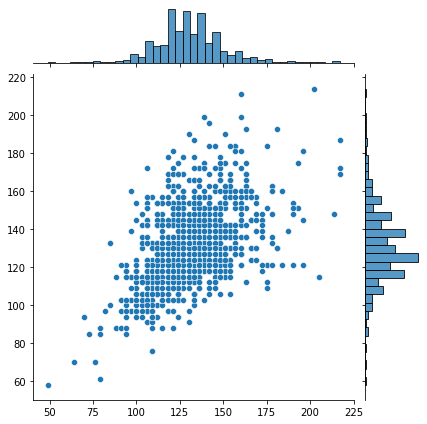

In [ ]:
sns.jointplot(dim2, dim1)

In [ ]:
batch_size = 32
epochs = 200
data_augmentation = True
num_classes = 2

In [ ]:
imread(u_cell).max()

0.8784314

In [ ]:
# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

In [ ]:

def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])

        num_filters_in = num_filters_out

    # add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
input_shape = (128,128,3)
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

In [ ]:
model.compile(loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

Learning rate:  0.001


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 128, 128, 16  64         ['conv2d_31[0][0]']              
 ormalization)                  )                                                           

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [ ]:
# prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [ ]:
image_gen = ImageDataGenerator(rotation_range = 20,
                               height_shift_range = 0.1,
                               width_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest') 

In [ ]:
image_shape = (132,132,3)
test_image_gen = image_gen.flow_from_directory(test_path, target_size= image_shape[:2],color_mode='rgb', batch_size= batch_size, class_mode= 'binary', shuffle = False)

Found 2600 images belonging to 2 classes.


In [ ]:
train_image_gen = image_gen.flow_from_directory(train_path, target_size= image_shape[:2],color_mode='rgb', batch_size= batch_size, class_mode= 'binary')


Found 24998 images belonging to 2 classes.


In [ ]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
'''if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # this will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)
    datagen.fit(x_train)
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        steps_per_epoch=len(x_train)//batch_size,
                        callbacks = callbacks)'''

"if not data_augmentation:\n    print('Not using data augmentation.')\n    model.fit(x_train, y_train,\n              batch_size=batch_size,\n              epochs=epochs,\n              validation_data=(x_test, y_test),\n              shuffle=True,\n              callbacks=callbacks)\nelse:\n    print('Using real-time data augmentation.')\n    # this will do preprocessing and realtime data augmentation:\n    datagen = ImageDataGenerator(\n        # set input mean to 0 over the dataset\n        featurewise_center=False,\n        # set each sample mean to 0\n        samplewise_center=False,\n        # divide inputs by std of dataset\n        featurewise_std_normalization=False,\n        # divide each input by its std\n        samplewise_std_normalization=False,\n        # apply ZCA whitening\n        zca_whitening=False,\n        # randomly rotate images in the range (deg 0 to 180)\n        rotation_range=0,\n        # randomly shift images horizontally\n        width_shift_range=0.1,\n 

In [ ]:
model.fit_generator(train_image_gen, epochs = 25, validation_data= test_image_gen, 
                    verbose = 1,
                    callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Learning rate:  0.001
Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 [==============================] - 279s 346ms/step - loss: 0.7660 - accuracy: 0.8860 - val_loss: 0.5393 - val_accuracy: 0.9288 - lr: 0.0010
Learning rate:  0.001
Epoch 2/25
782/782 [==============================] - 236s 301ms/step - loss: 0.4432 - accuracy: 0.9420 - val_loss: 0.4740 - val_accuracy: 0.8927 - lr: 0.0010
Learning rate:  0.001
Epoch 3/25
782/782 [==============================] - 237s 303ms/step - loss: 0.3361 - accuracy: 0.9470 - val_loss: 1.1667 - val_accuracy: 0.8385 - lr: 0.0010
Learning rate:  0.001
Epoch 4/25
782/782 [==============================] - 237s 303ms/step - loss: 0.2861 - accuracy: 0.9488 - val_loss: 0.6576 - val_accuracy: 0.8538 - lr: 0.0010
Learning rate:  0.001
Epoch 5/25
782/782 [==============================] - 237s 303ms/step - loss: 0.2638 - accuracy: 0.9463 - val_loss: 1.5141 - val_accuracy: 0.7362 - lr: 0.0010
Learning rate:  0.001
Epoch 6/25
782/782 [==============================] - 236s 302ms/step - loss: 0.2380 - accuracy: 0.9485 - 

In [ ]:
#scores = model.evaluate(x_test, y_test, verbose=1)


In [ ]:
model.evaluate_generator(test_image_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[1.0498868227005005, 0.745769202709198]

In [ ]:
losses = pd.DataFrame(model.history.history)

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
#losses[['accuracy','val_accuracy']].plot()

In [ ]:
losses

""
